# Inicializacion e imports

In [1]:
HOST = "http://127.0.0.1:3000/"

PROJECT_NAME = "NPF Detector"
EXPERIMENT_NAME = "512 Gaussian model"
EXPERIMENT_DESCRIPTION = "Inicializo con HCompV (sin args). Estimo con HERest (sin args). \
                          Guardo los archivos en dndlogdp."

%reload_ext autoreload

%autoreload 2

import src.visualization.visualize as viz
import src.HTK.htktools as htkt
import src.HTK.scripts as scripts

scripts.clean_interim()
scripts.clean_models()

# Inicializo Verta

In [2]:
from verta import Client

client = Client(HOST)
proj = client.set_project(PROJECT_NAME)
expt = client.set_experiment(EXPERIMENT_NAME)
run = client.set_experiment_run(desc=EXPERIMENT_DESCRIPTION)

connection successfully established
set existing Project: NPF Detector from personal workspace
set existing Experiment: 512 Gaussian model
created new ExperimentRun: Run 1009615949277780564117


# Logueo los archivos que voy a usar en el HTK

In [3]:
run.log_artifact("HTK_misc","../src/HTK/misc", overwrite=True)

scripts.display_artifact(which=['config.hcopy'])

upload complete (HTK_misc)
****   src/HTK/misc/config.hcopy   ****

 # Coding parameters
 SOURCEKIND = USER
 TARGETKIND = USER_D_A



# Preparo los datos

Convierto los datos crudos a formato HTK, separando 90% para entrenar y 10% para testear. Tambien creo los archivos necesarios para usar en HTK (train.scp, test.scp)

INFO:root:Converting raw files to HTK format ...
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Files converted OK!
/home/gfogwil/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
INFO:root:Creating labels ...
INFO:root:Labels created OK!


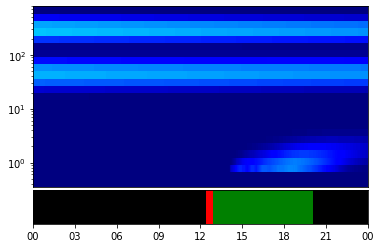

In [4]:
scripts.setup_data(convert_to_dndlogdp=True)

threshold = {'nuc_threshold': 0.7,       # 1/cm3/10min
             'con_threshold': 210,       # 1/m3^3/10min
             'coa_threshold': 2,         # 1/cm3/10min
             'dep_threshold': 2500}      # 1/m3^3/10min

viz.evaluate_hyperparameter_for_label('0.0-20150124.h5', threshold)
scripts.make_labels(threshold)

run.log_hyperparameters(threshold)

In [5]:
scripts.gen_scp_files()
scripts.gen_MLF()

INFO:root:Generating script (.scp) files...


Agrego las deltas y las aceleraciones tanto para test como para train:

In [6]:
# Test
n = htkt.HCopy(['-C', '../src/HTK/misc/config.hcopy',
        '-S', '../data/interim/test_hcopy.scp',
        '-T', 1])


run.log_observation('number_of_test_files', n)

# Train
n = htkt.HCopy(['-C', '../src/HTK/misc/config.hcopy',
        '-S', '../data/interim/train_hcopy.scp',
        '-T', 1])

run.log_observation('number_of_train_files', n)


### Inicializo el modelo de Markov

In [7]:
# Limpio todas todos los modelos y creo el modelo prototipo
scripts.clean_models()

In [8]:
most_trained_model = 0
htkt.HCompV(['-C', '../src/HTK/misc/config',
             '-S', '../data/interim/train.scp',
             '-M', '../models/hmm/' + str(most_trained_model),
             '-T', 1,
             '-f', 0.1,
             '-m',
             '../src/HTK/misc/proto'])

Calculating Fixed Variance
  HMM Prototype: ../src/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: ../models/hmm/0
227088 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory ../models/hmm/0
Var floor macros output to file ../models/hmm/0/vFloors



In [9]:
scripts.gen_hmmdefs()
scripts.gen_macros()

### Estimo los parametros

In [10]:
n = 3

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
run.log_artifact('model_1_gaussian', '../models/hmm/' + str(most_trained_model), overwrite=True)

Pruning-Off

Pruning-Off

Pruning-Off

upload complete (model_1_gaussian)


### Evaluo

In [11]:
htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(most_trained_model),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/3/macros -H ../models/hmm/3/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_3 ../src/HTK/misc/dict ../src/HTK/misc/monophones 



In [12]:
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(most_trained_model)])

for k,v in r.items():
    run.log_observation(k,v)

run.log_metric('correct_1_gaussian', r['WORD_Corr'])

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:35:21 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_3
------------------------ Overall Results --------------------------
SENT: %Correct=73.25 [H=115, S=42, N=157]
WORD: %Corr=37.80, Acc=37.80 [H=158, D=260, S=0, I=0, N=418]



### Edito el modelo, ahora uso 2 gaussianas

In [13]:
most_trained_model = 3
print("Modelo inicial:", most_trained_model)
number_of_gaussians = 2

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

print("Modelo Final:", most_trained_model)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_2gaussians', r['WORD_Corr'])

Modelo inicial: 3

Pruning-Off

Pruning-Off

Pruning-Off

upload complete (model_2_gaussian)
Modelo Final: 7
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/7/macros -H ../models/hmm/7/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_2 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:35:29 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_2
------------------------ Overall Results --------------------------
SENT: %Correct=73.25 [H=115, S=42, N=157]
WORD: %Corr=37.80, Acc=37.80 [H=158, D=260, S=0, I=0, N=418]



In [14]:
viz.evaluate_results('0-20150124',2)

IndexError: list index out of range

### Edito el modelo, ahora uso 4 gaussianas

In [ ]:
#most_trained_model = 6
number_of_gaussians = 4

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
print("Modelo final:", most_trained_model)    
    
run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_4_gaussians', r['WORD_Corr'])

In [ ]:
viz.evaluate_results()

### Edito el modelo, ahora uso 8 gaussianas

In [ ]:
#most_trained_model = 9
number_of_gaussians = 8

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            #'-p', 0,
            #'-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)

run.log_metric('correct_8_gaussians', r['WORD_Corr'])

### Edito el modelo, ahora uso 16 gaussianas

In [ ]:
#most_trained_model = 12
number_of_gaussians = 16

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_16_aussians', r['WORD_Corr'])

### Edito el modelo, ahora uso 32 gaussianas

In [ ]:
#most_trained_model = 15
number_of_gaussians = 32

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_32_gaussians', r['WORD_Corr'])

### Edito el modelo, ahora uso 64 gaussianas

In [ ]:
#most_trained_model = 18
number_of_gaussians = 64

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_64_gaussians', r['WORD_Corr'])

In [ ]:
viz.evaluate_results('0-20150124',64)

### Edito el modelo, ahora uso 128 gaussianas

In [ ]:
most_trained_model = 21
number_of_gaussians = 128

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_128_gaussians', r['WORD_Corr'])

### Edito el modelo, ahora uso 256 gaussianas

In [ ]:
most_trained_model = 24
number_of_gaussians = 256

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_256_gaussians', r['WORD_Corr'])

### Edito el modelo, ahora uso 512 gaussianas

In [ ]:
most_trained_model = 27
number_of_gaussians = 512

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_512_gaussians', r['WORD_Corr'])